In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, CuDNNLSTM
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import numpy as np
import seaborn as sns; sns.set()
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization

Using TensorFlow backend.


In [0]:

import numpy as np
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.summarization import bm25
import nltk
import numpy as np
import random
import pickle
import scipy
import sklearn
import tqdm

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Flatten,Input,Bidirectional,CuDNNLSTM
from keras.layers import Subtract,Lambda,Add,BatchNormalization
from keras.optimizers import Adam as adam
from keras.utils.vis_utils import model_to_dot	
from keras.utils import plot_model
from IPython.display import SVG
#SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [0]:
import keras 
import keras.backend as K
def softmax_(x):
  return keras.activations.softmax(x, axis=1)# creates some issue with the generation at the end of target string

def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [0]:
digits=["0","1","2","3","4","5","6","7","8","9"]
sep_char="|"
vocab = digits + [sep_char]
vocab_size=len(vocab) # for the  seperator "|"

### Transformer Encoder

In [0]:
# Hyperparamteres #
T=61 # please keep it ODD
d_model=50#  ≥ input_d
dk=50
dv=50
h=3
dff=200
P_drop=0.1
N=2
mha_activation="linear"
# Hyper paramteres #
#vocab_size=25
input_d=15

sent_inp=Input(shape=(T,))
input_embedding=Embedding(vocab_size + 1,input_d,input_length=T,trainable=True)(sent_inp)
pos_inp = Input(shape=(T,))
position_embedding=Embedding(T + 1,d_model - input_d,input_length=T,trainable=True)(pos_inp)
final_inp = Concatenate(axis=-1)([position_embedding,input_embedding])
sublayer_out = final_inp
alphas_list=[]
for n in np.arange(N):
  ################### LAYER ##################
  sublayer_in=sublayer_out # joining with last Layer
  i_v=sublayer_in # Values
  i_k=sublayer_in # Keys
  
  ############# SELF Attention SUBLAYER #############
  Dense_K=[Dense(dk,activation=mha_activation) for i in np.arange(h)]# multi heads
  Dense_Q=[Dense(dk,activation=mha_activation) for i in np.arange(h)]
  Dense_V=[Dense(dv,activation=mha_activation) for i in np.arange(h)]
  Dense_dmodel= Dense(d_model)
  all_times_out=[]
  for t in np.arange(T):# iterate with different queries.
    i_q = Lambda(lambda x : x[:,t,:])(sublayer_in) # Queries
    ######### MULTI HEAD ATTENTION #########
    all_heads=[]
    for i in np.arange(h): #
      k=Dense_K[i](i_k)# time distributed
      q=Dense_Q[i](i_q)# not time distributed
      v=Dense_V[i](i_v)# time distributed
      #### Scaled Dot Product Attention ####
      d=Dot(axes = -1)([k,q])
      d1=Lambda(lambda x: x/(np.sqrt(dk)))(d)
      alphas=Activation(softmax,name="head_"+str(i+1)+"time_"+str(t+1)+"layer"+str(n+1))(d1)
      alphas_list.append(alphas) # for purely visualization purposes
      contex_v = Dot(axes = 1)([alphas,v])
      #### Scaled Dot Product Attention ####
      all_heads.append(contex_v)
    concat = Concatenate(axis=1)(all_heads)
    final = Dense_dmodel(concat)
    final = RepeatVector(1)(final)#to create an extra one axis. (None, d_model) ---> (None,1,d_model) # so that later (None,T,d_model)
    all_times_out.append(final)
    ######### MULTI HEAD ATTENTION #########
  all_times_out=Concatenate(axis=1)(all_times_out) # T times (None,1,d_model) ----> (None,T,d_model)
  all_times_out=Dropout(P_drop)(all_times_out)
  sublayer_out = Add()([all_times_out,sublayer_in])# Residual connection
  sublayer_out = BatchNormalization()(sublayer_out)# default axis -1
  ############# SELF Attention SUBLAYER #############

  ############# Feed Forward SUBLAYER #############
  sublayer_in=sublayer_out
  dense1=Dense(dff,activation="relu")(sublayer_in)
  dense2=Dense(d_model,activation="linear")(dense1)
  dense2=Dropout(P_drop)(dense2)
  sublayer_out = Add()([dense2,sublayer_in])# Residual connection
  sublayer_out = BatchNormalization()(sublayer_out)# default axis -1
  ############# Feed Forward SUBLAYER #############
  
  ################### LAYER ##################

o=Dense(vocab_size-1,activation="softmax")(sublayer_out)#since delimiter wont come in output

model=Model(inputs=[sent_inp,pos_inp],outputs=[o])
visualize_model=Model(inputs=[sent_inp,pos_inp],outputs=[o]+alphas_list)
#model.summary()# just too big

In [303]:
model.count_params()

105160

In [0]:
#plot_model(model, to_file='model.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [305]:
sample=model.predict([np.random.randint(low=0,high=vocab_size,size=(1,T)),np.reshape(np.arange(T),(1,T))])
sample.shape

(1, 61, 10)

In [306]:
sample=visualize_model.predict([np.random.randint(low=0,high=vocab_size,size=(1,T)),np.reshape(np.arange(T),(1,T))])
assert np.array(sample[1:]).shape[0]== h*T*N
print(h*T*N,"attentions")

366 attentions


### Create Training Data from random numbers

In [0]:
def create_sample():
  sep_char = "|"
  t=int((T-1)/2)
  str_number1 = ("".join(random.sample(numbers*100,t)))
  str_number2 = ("".join(random.sample(numbers*100,t)))
  result = int(str_number1) + int(str_number2)
  str_result = str(result)
  input_numbers= str_number1+sep_char+str_number2
  assert len(input_numbers) == T
  return np.array(list(input_numbers)),np.array(list(str_result.zfill(T)))

In [308]:
create_sample()

(array(['4', '8', '0', '6', '1', '3', '5', '4', '1', '9', '8', '6', '4',
        '2', '8', '6', '7', '3', '5', '8', '1', '9', '2', '2', '3', '4',
        '0', '9', '1', '5', '|', '4', '0', '5', '9', '1', '0', '9', '3',
        '5', '7', '1', '0', '6', '8', '4', '5', '8', '1', '8', '4', '3',
        '7', '0', '1', '9', '7', '1', '9', '1', '8'], dtype='<U1'),
 array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '8', '8', '6', '5', '2', '4', '4', '7',
        '7', '6', '9', '7', '1', '1', '3', '2', '5', '5', '4', '2', '5',
        '6', '2', '4', '3', '1', '2', '8', '3', '3'], dtype='<U1'))

In [0]:
##create 10 digit random charachter sequences
data_size=7000
data=[create_sample() for i in range(data_size)]

In [310]:
input_data,output_data=list(zip(*data))
input_data=np.array(input_data)
output_data=np.array(output_data)
input_data.shape,output_data.shape

((7000, 61), (7000, 61))

In [0]:
seqdata = np.array([[vocab.index(i) for i in j] for j in input_data])
target=to_categorical(output_data,num_classes=len(digits))

### Training

In [0]:
custom_adam=adam(lr=0.011, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(custom_adam,loss="categorical_crossentropy",metrics=["accuracy"])

In [317]:
arange=np.tile(np.arange(T),data_size).reshape(data_size,T)# for position
history=model.fit([seqdata,arange],target,epochs=100,batch_size=100, verbose=1) 

Epoch 1/100
7000/7000 [==============================] - 123s 18ms/step - loss: 1.2429 - acc: 0.5409
Epoch 2/100
7000/7000 [==============================] - 27s 4ms/step - loss: 1.1454 - acc: 0.5501
Epoch 3/100
7000/7000 [==============================] - 27s 4ms/step - loss: 1.1445 - acc: 0.5517
Epoch 4/100
7000/7000 [==============================] - 27s 4ms/step - loss: 1.1435 - acc: 0.5544
Epoch 5/100
7000/7000 [==============================] - 27s 4ms/step - loss: 1.1395 - acc: 0.5584
Epoch 6/100
7000/7000 [==============================] - 27s 4ms/step - loss: 1.1341 - acc: 0.5626
Epoch 7/100
7000/7000 [==============================] - 27s 4ms/step - loss: 1.1306 - acc: 0.5655
Epoch 8/100
7000/7000 [==============================] - 27s 4ms/step - loss: 1.1284 - acc: 0.5676
Epoch 9/100
7000/7000 [==============================] - 27s 4ms/step - loss: 1.1260 - acc: 0.5688
Epoch 10/100
7000/7000 [==============================] - 27s 4ms/step - loss: 1.1199 - acc: 0.5730
Epoch 1

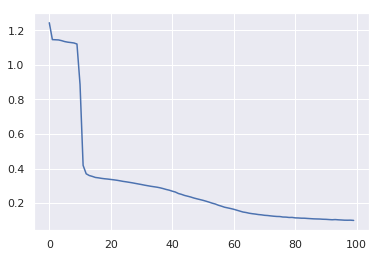

In [330]:
plt.plot(history.history["loss"])

### Create Testing Set

In [0]:
##create 10 digit random charachter sequences for Testing purposes
Tdata_size=500
Tdata=[create_sample() for i in range(Tdata_size)]
Tinput_data,Toutput_data=list(zip(*Tdata))
Tinput_data=np.array(Tinput_data)
Toutput_data=np.array(Toutput_data)
Tinput_data.shape,Toutput_data.shape
Tseqdata = np.array([[vocab.index(i) for i in j] for j in Tinput_data])

In [383]:
Tseqdata[0],model.evaluate([Tseqdata,np.tile(np.arange(T),Tdata_size).reshape(Tdata_size,T) ],to_categorical(Toutput_data))

500/500 [==============================] - 1s 2ms/step


(array([ 4,  7,  9,  9,  3,  8,  6,  9,  7,  6,  5,  3,  3,  0,  1,  6,  4,
         6,  2,  8,  3,  7,  7,  7,  7,  2,  6,  5,  0,  8, 10,  3,  4,  9,
         9,  0,  5,  0,  8,  6,  5,  1,  8,  7,  8,  6,  5,  7,  7,  4,  6,
         6,  2,  3,  0,  6,  7,  8,  2,  1,  0]),
 [0.09382098877429962, 0.9575737686157226])

### Results

In [0]:
def showresults(Tseqdata):
  #Tseqdata=np.array([np.array([charachters.index(j) for j in i]) for i in data])
  items=[]
  for ind,sample in enumerate(Tseqdata):
    arange=np.tile(np.arange(T),1).reshape(1,T) 
    ouput=model.predict([sample.reshape(1,T),arange])
    ouput=np.array(ouput)
    ouput=np.argmax(ouput,axis=-1).reshape(1,T)[0]
    ouput="".join([vocab[int(j)] for j in ouput])
    iput="".join([vocab[i] for i in sample])
    items.append([iput,ouput])
  return items

def diff_letters(a,b):
    return sum ( a[i] != b[i] for i in range(len(a)) )

Average number of diffrent digits on Testing 2.588


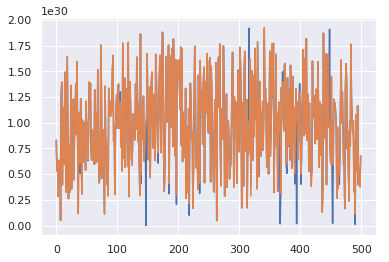

In [385]:
results = showresults(Tseqdata)## Testing Data
inp,out = list(zip(*results))
gt = [int(i.split("|")[0])+int(i.split("|")[1]) for i in inp]#actual sum
act = [int(i) for i in out]#output sum
plt.plot(act)
plt.plot(gt)
# Average number of diffrent digits on Testing
print("Average number of diffrent digits on Testing",np.average([diff_letters(str(gt[i]).zfill(T),str(act[i]).zfill(T)) for i in np.arange(Tdata_size)]))

Average number of diffrent digits on Training 2.224


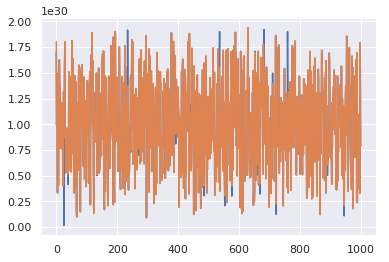

In [388]:
results = showresults(seqdata[:1000])## Training Data
inp,out = list(zip(*results))
gt = [int(i.split("|")[0])+int(i.split("|")[1]) for i in inp]#actual sum
act = [int(i) for i in out]#output sum
plt.plot(act)
plt.plot(gt)
# Average number of diffrent digits on Testing
print("Average number of diffrent digits on Training",np.average([diff_letters(str(gt[i]).zfill(T),str(act[i]).zfill(T)) for i in np.arange(Tdata_size)]))

In [0]:
def custom_sum(number1,number2):
  n1=str(number1)
  n2=str(number2)
  sep_char = "|"
  t=int((T-1)/2)
  sn1=n1.zfill(t)
  sn2=n2.zfill(t)
  input_number = sn1+sep_char+sn2
  assert len(input_number) == T
  arange=np.tile(np.arange(T),1).reshape(1,T) 
  seq_inp = np.array([vocab.index(i) for i in input_number])
  ouput=model.predict([seq_inp.reshape(1,T),arange])
  answer = np.argmax(ouput,axis=-1).reshape(1,T)[0]
  answer = [str(i) for i in answer]
  return int("".join(list(answer))[-max(len(n1),len(n2))-1:])

In [451]:
custom_sum(1000000,4564546),custom_sum(123456789,123456789),custom_sum(121212121212121212,343434343434343434),custom_sum(1111111111,7777777777777777),custom_sum(3242345453879807867,353263754857703436431526)

(5564545,
 246812578,
 464646464646464646,
 7777778888888887,
 353266997103157306239493)

In [452]:
3242345453879807867+353263754857703436431526

353266997203157316239393

### Visualization

In [0]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

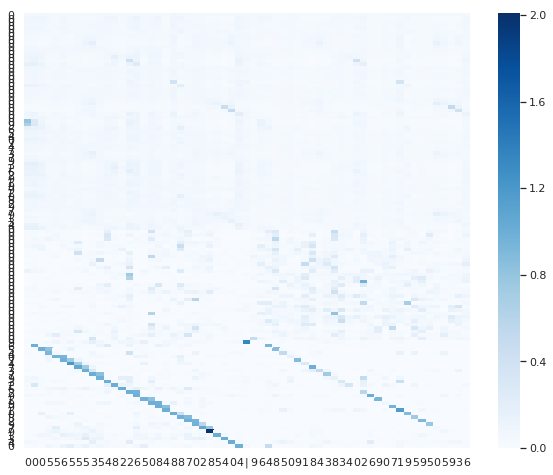

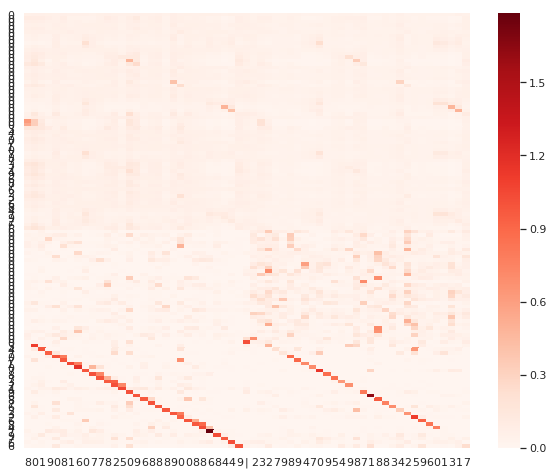

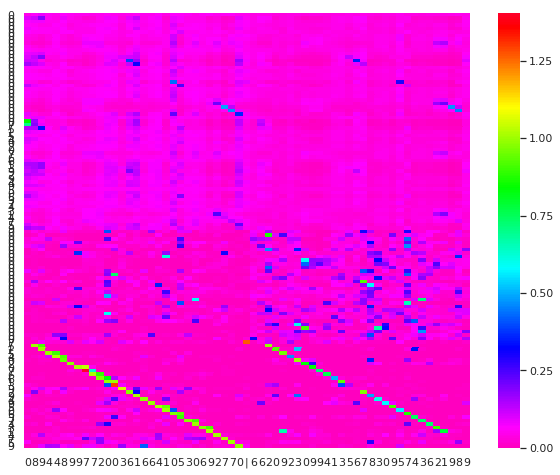

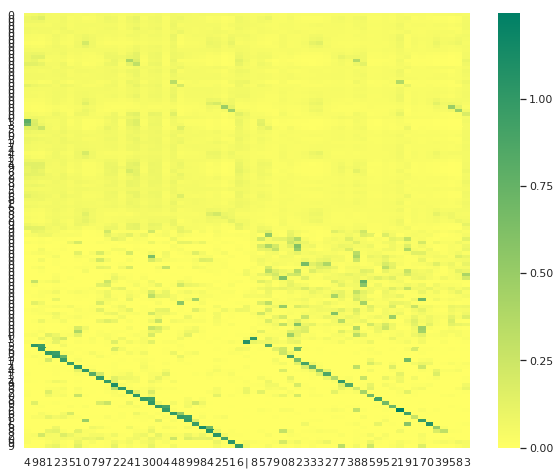

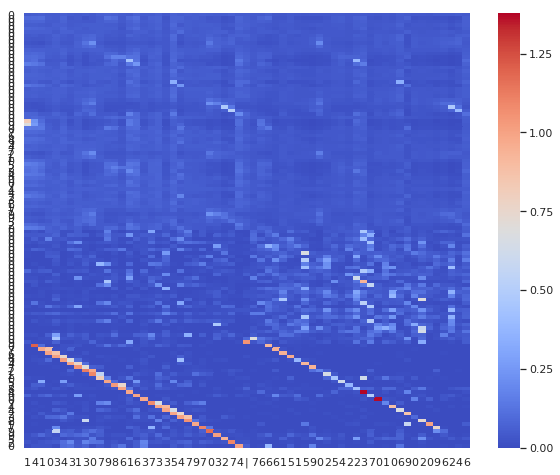

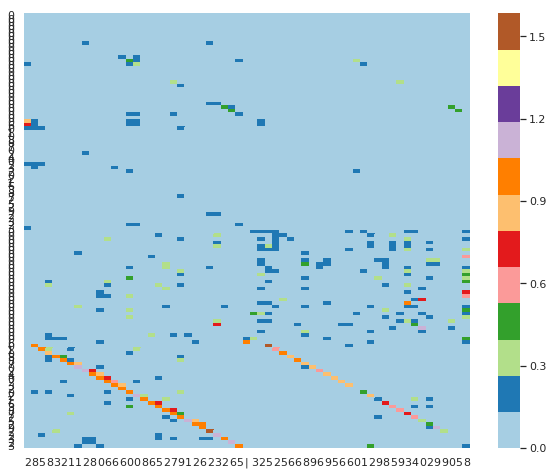

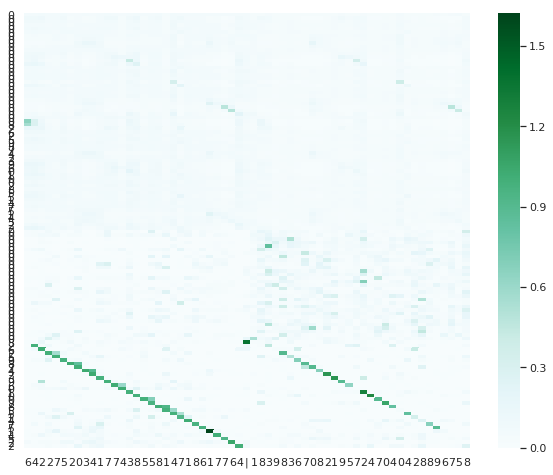

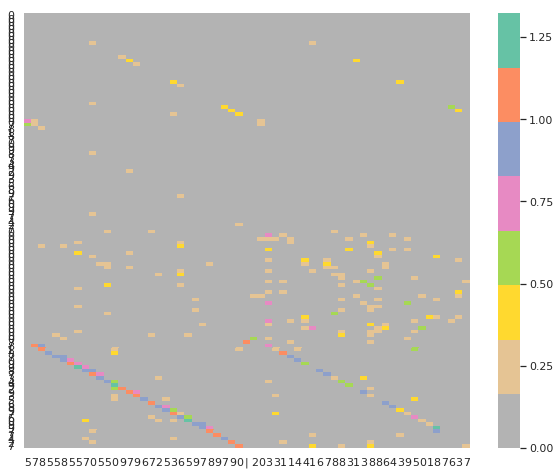

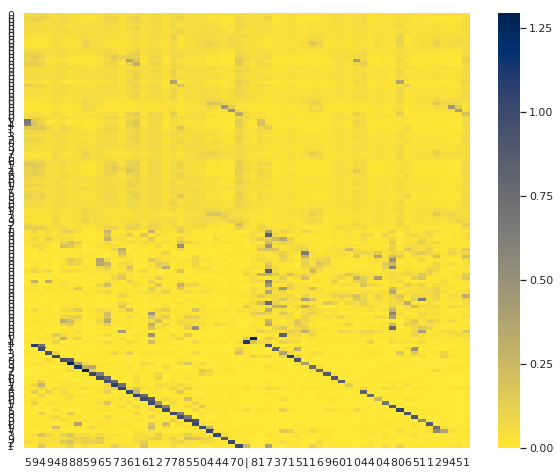

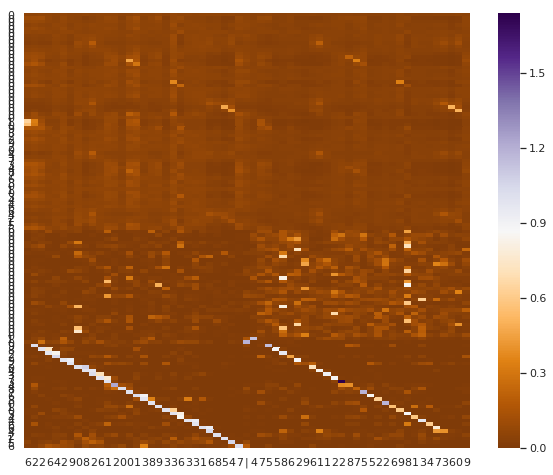

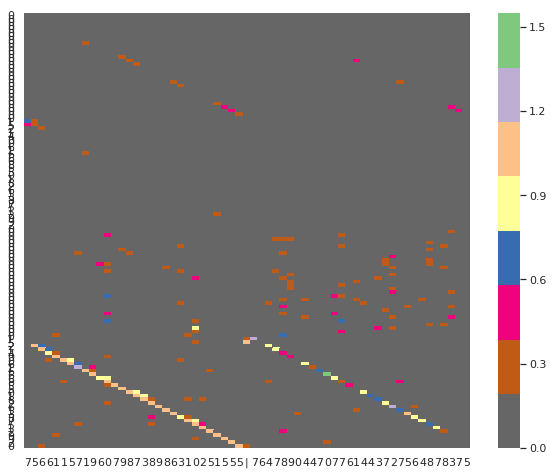

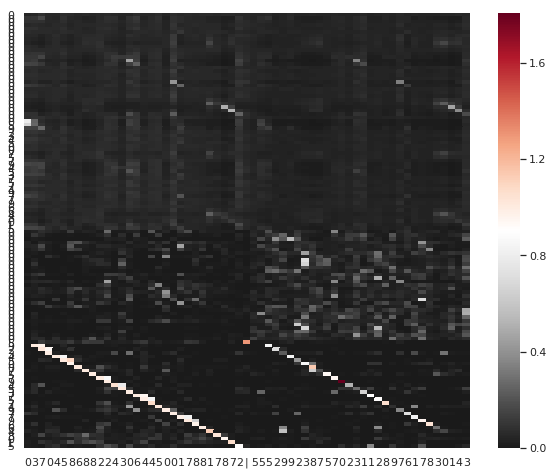

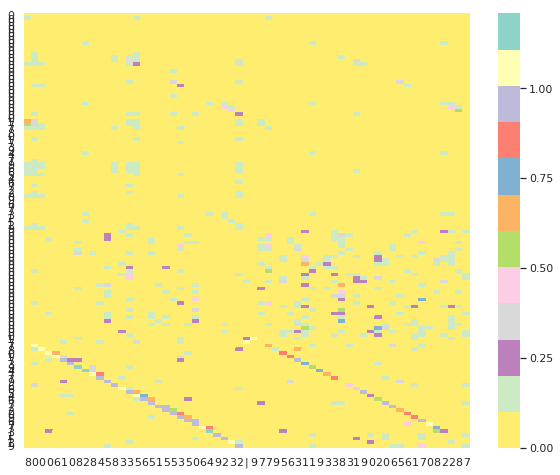

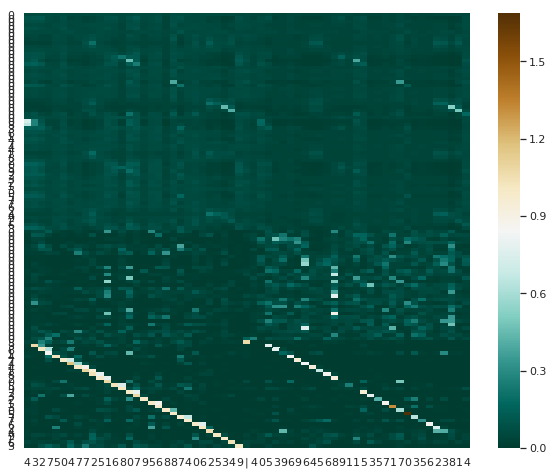

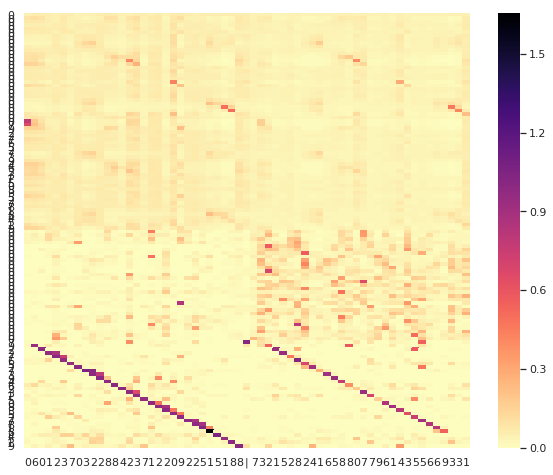

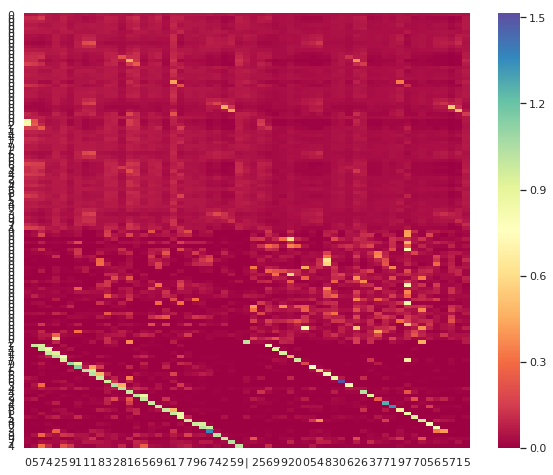

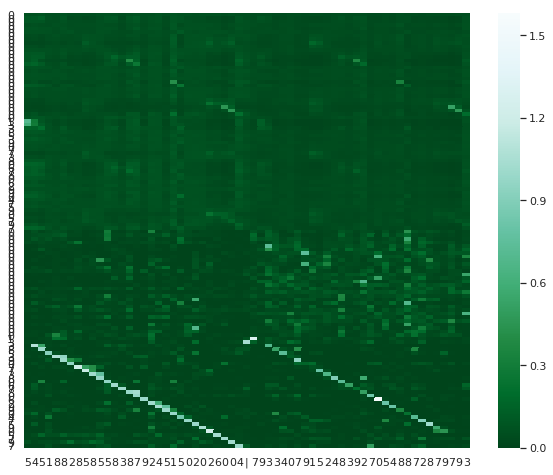

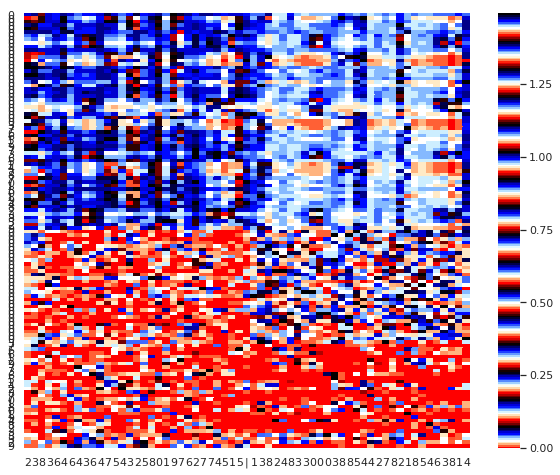

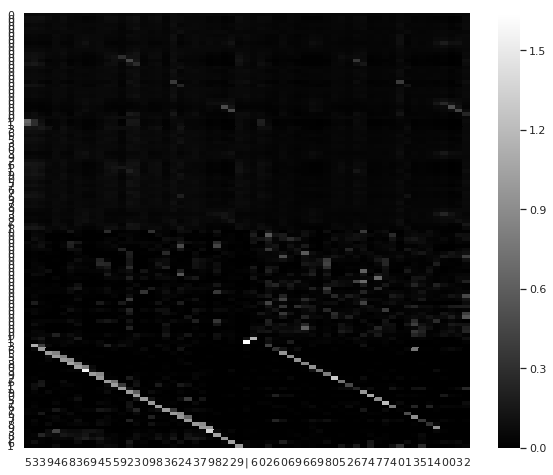

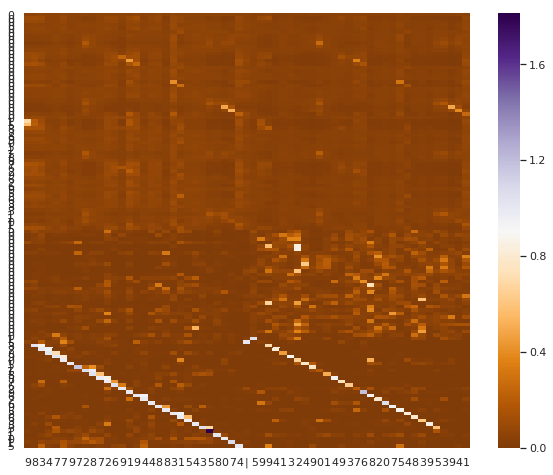

In [358]:
for bs in  random.sample(range(1, 100), 20):       
  arange=np.tile(np.arange(T),1).reshape(1,T)
  inp=Tseqdata[bs].reshape(1,T)
  o=visualize_model.predict([inp,arange])
  y=o[0]
  o=o[1:]
  o=np.array(o)
  o=o.reshape(N*T*h,T)
  t1=np.array(list(chunks(o,h)))
  t2=np.sum(t1,axis=1)
  #y=y.swapaxes(0,1)[0]
  y=np.argmax(y,axis=-1)
  y=y[0]
  xlabels= [vocab[j] for j in Tseqdata[bs]]
  ylabels=[vocab[j] for j in y]  
  fig, ax = plt.subplots(figsize=(10,8))
  indic=[]
  [indic.extend([" "," "," "," "," "," "," "," "," "," "," "," "," "," "," "," ",i+1]*int(len(ylabels)/18)) for i in np.arange(N)]
  sns.heatmap(t2,xticklabels=xlabels,yticklabels=ylabels*2,cmap=random.choice(["Accent","Accent_r","Blues","Blues_r","BrBG","BrBG_r","BuGn","BuGn_r","BuPu","BuPu_r","CMRmap","CMRmap_r","Dark2","Dark2_r","GnBu","GnBu_r","Greens","Greens_r","Greys","Greys_r","OrRd","OrRd_r","Oranges","Oranges_r","PRGn","PRGn_r","Paired","Paired_r","Pastel1","Pastel1_r","Pastel2","Pastel2_r","PiYG","PiYG_r","PuBu","PuBuGn","PuBuGn_r","PuBu_r","PuOr","PuOr_r","PuRd","PuRd_r","Purples","Purples_r","RdBu","RdBu_r","RdGy","RdGy_r","RdPu","RdPu_r","RdYlBu","RdYlBu_r","RdYlGn","RdYlGn_r","Reds","Reds_r","Set1","Set1_r","Set2","Set2_r","Set3","Set3_r","Spectral","Spectral_r","Wistia","Wistia_r","YlGn","YlGnBu","YlGnBu_r","YlGn_r","YlOrBr","YlOrBr_r","YlOrRd","YlOrRd_r","afmhot","afmhot_r","autumn","autumn_r","binary","binary_r","bone","bone_r","brg","brg_r","bwr","bwr_r","cividis","cividis_r","cool","cool_r","coolwarm","coolwarm_r","copper","copper_r","cubehelix","cubehelix_r","flag","flag_r","gist_earth","gist_earth_r","gist_gray","gist_gray_r","gist_heat","gist_heat_r","gist_ncar","gist_ncar_r","gist_rainbow","gist_rainbow_r","gist_stern","gist_stern_r","gist_yarg","gist_yarg_r","gnuplot","gnuplot2","gnuplot2_r","gnuplot_r","gray","gray_r","hot","hot_r","hsv","hsv_r","icefire","icefire_r","inferno","inferno_r","jet","jet_r","magma","magma_r","mako","mako_r","nipy_spectral","nipy_spectral_r","ocean","ocean_r","pink","pink_r","plasma","plasma_r","prism","prism_r","rainbow","rainbow_r","rocket","rocket_r","seismic","seismic_r","spring","spring_r","summer","summer_r","tab10","tab10_r","tab20","tab20_r","tab20b","tab20b_r","tab20c"]))